In [2]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [3]:
class AdalineGD:

    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta                      # learning rate
        self.n_iter = n_iter                # number of iterations on dataset
        self.random_state = random_state    # random generator key

    def fit(self, X, y):
         # generate random weights, size is same as number of features
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])

        # init bias to 0
        self.b_ = np.float_(0.)

        self.losses_ = []

         # iterate over dataset n_iter times
        for _ in range(self.n_iter):
            # calculate input for activation function
            net_input = self.net_input(X)
            # feed to activation function
            output = self.activation(net_input)
            # error = y_true - activation function output
            errors = y - output

            # update weights
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            # update bias
            self.b_ += self.eta * 2.0 * errors.mean()

            # MSE loss
            loss = (errors**2).mean()
            self.losses_.append(loss)
        
        return self

    def net_input(self, X):
        # z = wTx + b
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        # Adaline is linear activation, just return input
        return X

    def predict(self, X):
        # if z >= 0.5, return 1, else 0
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

In [4]:
# read iris dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
df = pd.read_csv(url, header=None, encoding='utf-8')
df.tail()

,0,1,2,3,4
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


In [5]:
# only use the first two classes for now (perceptron is binary classification)
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', 0, 1)

# only use the 1st and 3rd feature
X = df.iloc[0:100, [0, 2]].values

In [6]:
# standardize the features - substract each sample by the feature mean, then divide by std
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

In [7]:
# visualize decision boundary of 2D datasets

def plot_decision_regions(X, y, classifier, resolution=0.02):
    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {cl}',
                    edgecolor='black')

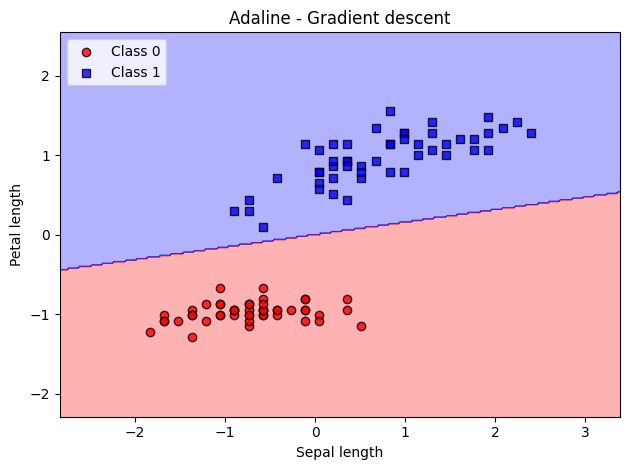

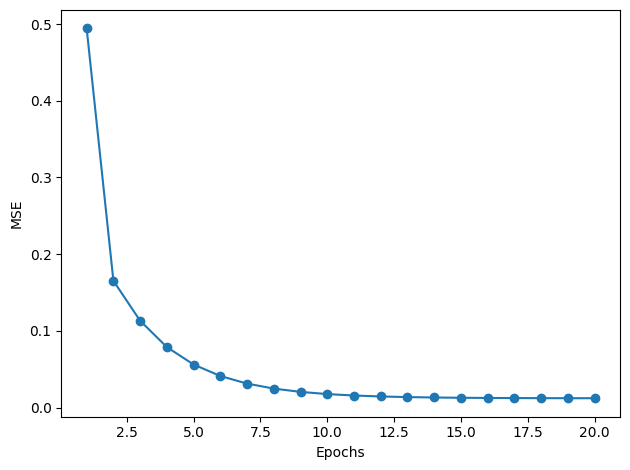

In [8]:
ada_gd = AdalineGD(eta=0.5, n_iter=20)
ada_gd.fit(X_std, y)

# plot decision region
plot_decision_regions(X_std, y, ada_gd)
plt.title('Adaline - Gradient descent')
plt.xlabel('Sepal length (standardized)')
plt.ylabel('Petal length (standardized)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# plot losses per epoc
plt.plot(range(1, len(ada_gd.losses_) + 1), ada_gd.losses_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.tight_layout()
plt.show()

In [11]:
class AdalineSGD:

    def __init__(self, eta=0.01, n_iter=50, shuffle=True, random_state=1):
        self.eta = eta                      # learning rate
        self.n_iter = n_iter                # number of iterations on dataset
        self.w_initialized = False          # flag to check whether weights have been initialized (for online training)
        self.shuffle = shuffle              # shuffle the training data for each epoch
        self.random_state = random_state    # random generator key

    def fit(self, X, y):
        self._initialize_weights(X.shape[1])

        self.losses_ = []

         # iterate over dataset n_iter times
        for _ in range(self.n_iter):
            # Shuffle data at every epoch, since SGD updates weights after each sample
            if self.shuffle:
                X, y = self._shuffle(X, y)

            losses = []  # track the loss of each sample

            for xi, yi in zip(X, y):
                losses.append(self._update_weights(xi, yi))

            # average loss of each sample in this epoch
            avg_loss = np.mean(losses)

            # keep track of avg loss of each epoch
            self.losses_.append(avg_loss)
        
        return self

    def partial_fit(self, X, y):
        # train without initializing weights (for new data in online training)
        
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])

        if y.ravel().shape[0] > 1:              # if the new data has more than 1 sample
            for xi, yi in zip(X, y):
                self._update_weights(xi, yi)
        else:                                   # if the new data only has 1 sample
            self._update_weights(X, y)

        return self

    def _shuffle(self, X, y):
        r = self.rgen.permutation(len(y))  # generate random sequence of unique numbers
        return X[r], y[r]

    def _initialize_weights(self, num_features):
        # generate random weights, size is same as number of features
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=num_features)

        # init bias to 0
        self.b_ = np.float_(0.)

        self.w_initialized = True

    def _update_weights(self, xi, yi):
        # calculate input for activation function
        net_input = self.net_input(xi)
        # feed to activation function
        output = self.activation(net_input)
        # error = y_true - activation function output
        error = yi - output

        # update weights
        self.w_ += self.eta * 2.0 * xi * error

        # update bias
        self.b_ += self.eta * 2.0 * error

        # MSE loss
        loss = error**2
        return loss


    def net_input(self, X):
        # z = wTx + b
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        # Adaline is linear activation, just return input
        return X

    def predict(self, X):
        # if z >= 0.5, return 1, else 0
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

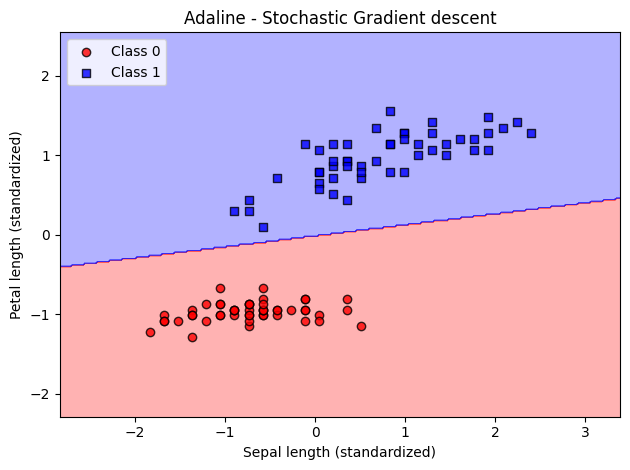

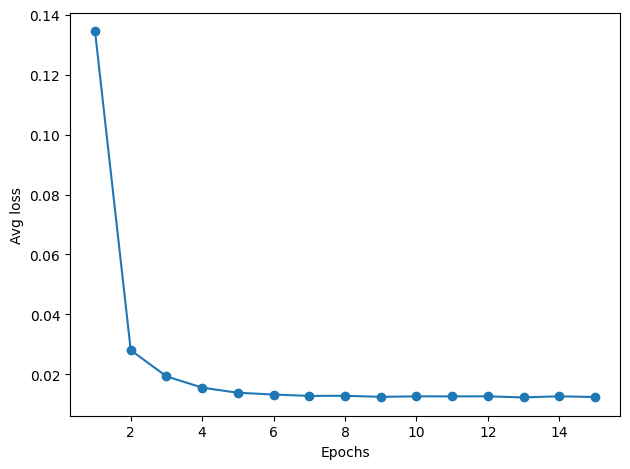

In [12]:
ada_sgd = AdalineSGD(eta=0.01, n_iter=15, random_state=1)
ada_sgd.fit(X_std, y)

# plot decision region
plot_decision_regions(X_std, y, ada_sgd)
plt.title('Adaline - Stochastic Gradient descent')
plt.xlabel('Sepal length (standardized)')
plt.ylabel('Petal length (standardized)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# plot losses per epoc
plt.plot(range(1, len(ada_sgd.losses_) + 1), ada_sgd.losses_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Avg loss')
plt.tight_layout()
plt.show()